# Hybrid Solar Cell Defect Detection System
Integrating EfficientNet and Dynamic
Heatmap Visualizations


Isha Patil,  
Department of Artificial Intelligence and Data Science Vishwakarma Institute of Information Technology Pune.



Prabhiman Raut,     
Department of Artificial Intelligence and Data Science Vishwakarma Institute of Information Technology Pune.


Rachana Sathe,   
Department of Artificial Intelligence and Data Science Vishwakarma Institute of Information Technology Pune.


Ratna Patil,  
Department of Artificial Intelligence and Data Science Vishwakarma Institute of Information Technology Pune,

In [4]:
import os

In [ ]:
# import required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from utils.elpv_reader import load_dataset
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

# Dataset Exploration

## Loading the dataset

In [6]:
def load_data():
  images, probas, labels = load_dataset()

  # Convert the type of the solar module 
  # to numerical values
  labels[labels == "mono"] = 0
  labels[labels == "poly"] = 1

  # Convert the probabilities to classes
  probas[probas >= 0.5] = 1. # the cell is defective
  probas[probas < 0.5] = 0. # the cell is not defective

  # Convert grayscale to rgb
  # This is needed to adapt the data
  # to the model's input format
  rgb_imgs = np.repeat(images[..., np.newaxis],3,-1)
  
  # The images and the type of the cell
  # are going to be the inputs to our model
  X1 = rgb_imgs
  X2 = labels

  # The probabilities of being defective
  # are going to be the outputs of our model
  Y = probas

  return X1,X2,Y

In [7]:
X1,X2,Y = load_data()

## Visualizing the data

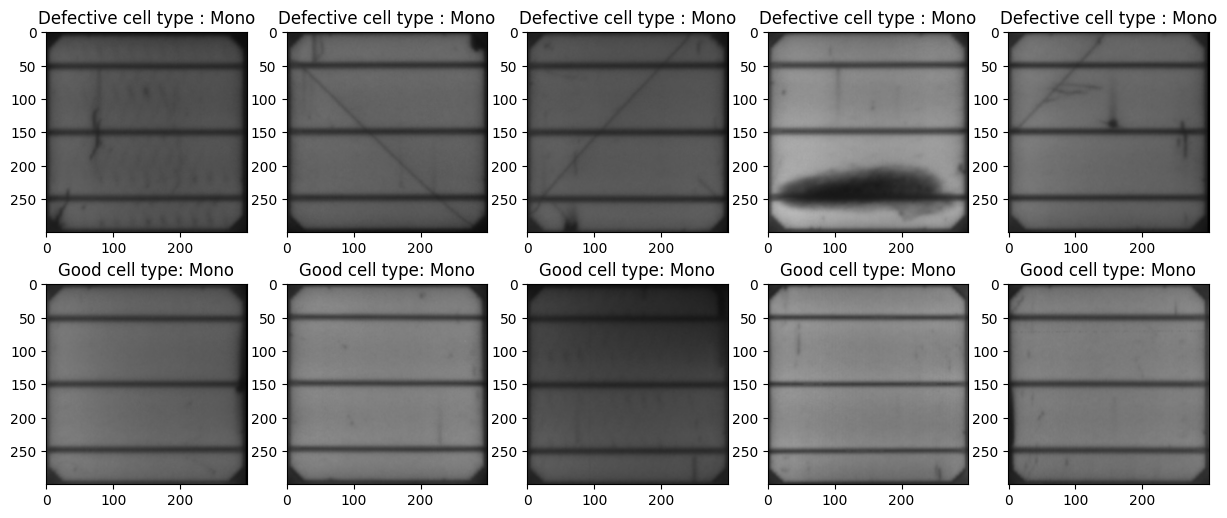

In [8]:
import matplotlib.pyplot as plt

defective_images = X1[Y == 1][:10]
non_defective_images = X1[Y == 0][:5]

cell_types_def = X2[Y == 1.][:5]
cell_types_ndef = X2[Y ==0.][:5]

plt.figure(figsize=(15,6))

for i in range(5):
    plt.subplot(2,5,i+1)
    plt.imshow(defective_images[i,...])
    plt.title("Defective cell type : "+ ("Poly" if cell_types_ndef[i-5] == 1 else "Mono"))

for i in range(5,10):
    plt.subplot(2,5,i+1)
    plt.imshow(non_defective_images[i-5,...])
    plt.title(f"Good cell type: "+ ("Poly" if cell_types_ndef[i-5] == 1 else "Mono"))

## Exploring the range of pixel intensities

In [9]:
min_intensity = np.min(X1)
max_intensity = np.max(X1)

print(f"The range of pixel intensities is between {min_intensity}-{max_intensity}")

The range of pixel intensities is between 0-255


## Exploring the target class distribution

In [10]:
pos_class = np.sum(Y)/len(Y)*100
neg_class = (len(Y)-np.sum(Y))/len(Y)*100

print(f'The dataset has {np.round(pos_class,2)} % defective cells and {np.round(neg_class,2)} % non-defective cells')

The dataset has 31.29 % defective cells and 68.71 % non-defective cells


## Splitting the data

In [11]:
# Convert target variable to binary class matrix
Y = to_categorical(Y)
# splitting the dataset
# to train and validation
X1_train,X1_val,Y_train,Y_val = train_test_split(X1,Y,test_size=0.2,random_state=13,stratify=Y)
X2_train,X2_val,Y_train,Y_val = train_test_split(X2,Y,test_size=0.2,random_state=13,stratify=Y)

print(f"Training set size: {X1_train.shape} \nValidation set size: {X1_val.shape}")

Training set size: (2099, 300, 300, 3) 
Validation set size: (525, 300, 300, 3)


# Data Preprocessing

In [12]:
Y_train = to_categorical(Y_train,num_classes=2)
Y_val = to_categorical(Y_val,num_classes=2)

In [13]:
BATCH_SIZE = 32
# this is the default size used by most of the pretrained Keras models
image_size = (224, 224)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        samplewise_center=False,
        samplewise_std_normalization=False,
        rescale=1./255,
        shear_range=0.07, # do some data augmentation here
        zoom_range=0.2,
        rotation_range=30,
        horizontal_flip=True,
        vertical_flip=True)

# create testing and validation data generator without augmentation
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        samplewise_center=False, 
        samplewise_std_normalization=False,
        rescale=1./255
        )



In [14]:
train_ds = train_datagen.flow(x=tf.image.resize(X1_train,size=(224,224)),
                              y=Y_train, 
                              batch_size=BATCH_SIZE)
val_ds = val_datagen.flow(x=tf.image.resize(X1_val,size=(224,224)),
                          y=Y_val,
                          batch_size=BATCH_SIZE)

# Building the model

In [15]:
# base_model = tf.keras.applications.EfficientNetV2B2(input_shape=input_shape,
#                                                      input_tensor=inputs,
#                                                      include_top=False,
#                                                      weights='imagenet',
#                                                   include_preprocessing=False,
#                                                    )
# inputs = tf.keras.Input(shape=input_shape)

# Define the input shape
input_shape = (224, 224, 3)  # Adjust the shape according to your data

# Define the input tensor
inputs = tf.keras.Input(shape=input_shape)

# Initialize the base model
base_model = tf.keras.applications.EfficientNetV2B2(input_shape=input_shape,
                                                    input_tensor=inputs,
                                                    include_top=False,
                                                    weights='imagenet',
                                                    include_preprocessing=False)


In [16]:
# Freezing all convoltional layers
# in the base_model
base_model.trainable = False

# Transfer Learning EfficientNet

In [17]:
def create_transfer_learning_model( 
                                   fine_tune=False,
                                   fine_tune_at=None,
                                   input_shape=(224,224,3),
                                   base_learning_rate = 0.01
                                   ):
  

    inputs = tf.keras.Input(shape=input_shape)
    base_model = tf.keras.applications.EfficientNetV2B2(input_shape=input_shape, 
                                                     include_top=False,
                                                     input_tensor=inputs,
                                                     weights='imagenet',
                                                     include_preprocessing=False,
                                                   )
    # Freeze the base model
    base_model.trainable = False
    
    if fine_tune :
        if not fine_tune_at:
            raise Exception("You should specify from which"+
                            " layer the model will be fine tuned"
                            )
        else:
            base_model.trainable = True
            
            # Freeze the lowest layers 
            # and fine tune the top layers
            # starting from index "fine_tune_at"
            for layer in base_model.layers[:fine_tune_at]:
                layer.trainable = False
  
    x = base_model.output
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    outputs = layers.Dense(2,activation="softmax")(x)
    
    model = tf.keras.Model(inputs, outputs)

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                  loss= tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                  metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return model, base_model
  
model, base_model = create_transfer_learning_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 112, 112,  │      2,304 │ block1a_project_… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 112, 112,  │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 112, 112,  │          0 │ block1b_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 112, 112,  │          0 │ block1b_project_… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 112, 112,  │          0 │ block1b_drop[0][… │
│                     │ 16)               │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 56, 56,    │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 56, 56,    │        128 │ block2a_project_

 Total params: 8,783,456 (33.51 MB)

 Trainable params: 8,450 (33.01 KB)

 Non-trainable params: 8,775,006 (33.47 MB)

In [18]:
from sklearn.utils import class_weight
import numpy as np

# # Calculate the weights for each class so that we can balance the data
# weights = class_weight.compute_class_weight(class_weight = "balanced",
#                                         classes = np.unique(Y_train),
#                                         y = Y_train)
# # weights should be a dictionary
# # 
# weights = dict(zip(np.unique(Y_train), weights))

# Ensure Y_train is converted to class labels (if one-hot encoded)
if isinstance(Y_train, np.ndarray) and len(Y_train.shape) > 1 and Y_train.shape[1] > 1:
    y_train_labels = np.argmax(Y_train, axis=1)  # Convert one-hot to class labels
elif isinstance(Y_train, np.ndarray) and len(Y_train.shape) == 1:
    y_train_labels = Y_train  # Already in class label format
else:
    raise ValueError("Y_train must be a numpy array.")

# Ensure y_train_labels is a 1D array
y_train_labels = np.array(y_train_labels).flatten()

# Calculate the class weights
weights = class_weight.compute_class_weight(class_weight="balanced",
                                            classes=np.unique(y_train_labels),
                                            y=y_train_labels)

# Convert the weights into a dictionary
weights = dict(zip(np.unique(y_train_labels), weights))

print(weights)  # To check the output

{0: 1.0, 1: 1.0}


In [30]:
# Define Callbacks to save the best model
if not os.path.exists("./models/"):
    os.makedirs("./models/")
  
chkp_filepath= "./models/best_efficient_net_b2_final2_{epoch:02d}.keras"
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    chkp_filepath, 
    verbose=1,
    save_best_only=True,
    monitor="val_categorical_accuracy",
    mode='max',
    save_freq="epoch")

filename='logs_effecient_net_b2_final.csv'
history_logger= tf.keras.callbacks.CSVLogger(filename, separator=",", append=True)

'Custom callback to decrease learning rate by a factor of 3 every 3rd epoch'
class DecreaseLR(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch > 4 and epoch % 2 == 0:
            self.model.optimizer.lr = self.model.optimizer.lr / 3

In [32]:
# tf.random.set_seed(64)

# initial_epochs = 18

# loss0, accuracy0 = model.evaluate(val_ds)

import numpy as np
import tensorflow as tf

# Assuming val_ds is a NumpyArrayIterator, retrieve the full dataset
val_features, val_labels = val_ds[0]  # Get features and labels from the first batch

# Convert to a tf.data.Dataset
val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels))

# Define a preprocessing function
def preprocess_labels(features, labels):
    labels = tf.argmax(labels, axis=-1)  # Convert to class labels
    return features, labels

# Map the preprocessing function to the dataset
val_ds = val_ds.map(preprocess_labels)

# Batch the dataset (optional but recommended)
val_ds = val_ds.batch(32)  # Adjust the batch size as needed

# Now evaluate the model
loss0, accuracy0 = model.evaluate(val_ds)


TypeError: '_BatchDataset' object is not subscriptable

In [21]:
from sklearn.utils import class_weight


# Calculate the weights for each class so that we can balance the data
# y = np.argmax(Y_train,axis=-1)
# weights = class_weight.compute_class_weight(class_weight = "balanced",
#                                        classes = np.unique(y),
#                                        y = y)
# weights = dict(zip(np.unique(Y_train), weights))


weights = {0.0:0.5, 1.0:1.5}

initial_epochs = 18
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds,
                    callbacks=[history_logger, checkpoint,DecreaseLR()],
                    class_weight=weights
                    )


c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


TypeError: only length-1 arrays can be converted to Python scalars

## Model Evaluation

In [21]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


NameError: name 'history' is not defined

## Visualize Predictions

In [7]:
# Load the best model trained in the previous phase
# Notice that here I changed its name
# So that you don't confuse it with your saved model
# When reproducing the code
best_model = tf.keras.models.load_model("./models/best_model.h5")# Replace the path here with the path to your best model

1/1 [==============================] - 0s 202ms/step


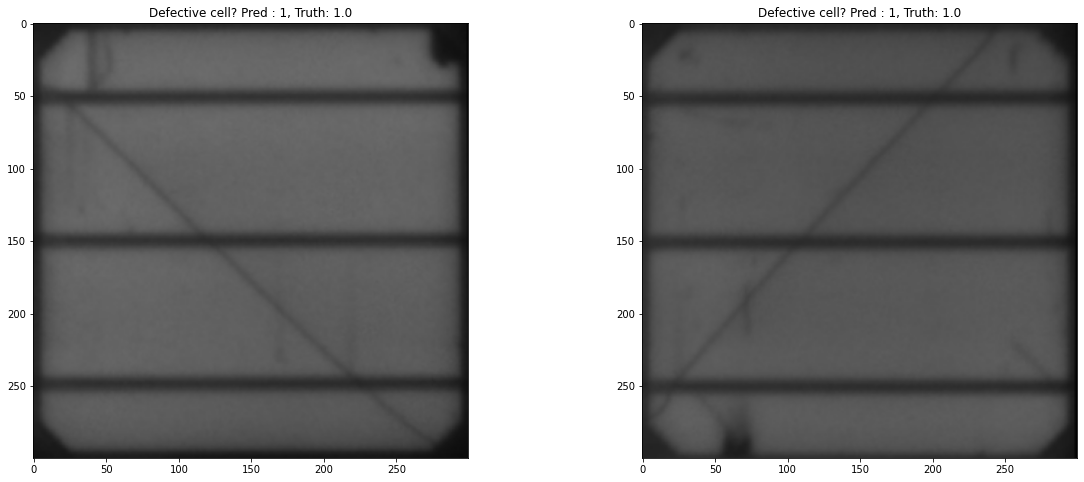

In [20]:
# Let's load only 2 images 
# from the defective cells
# Elsewhere we might run out of resources
# When using GradCam
image_btch = X1[Y == 1][1:3]
labels = Y[Y== 1][1:3]

# Preprocessing the images
images = tf.image.resize(image_btch,size=(224,224))/255.

# Running inference
predictions = best_model.predict(images)
predictions = tf.argmax(predictions,axis=-1)

plt.figure(figsize=(20,8))

for i in range(2):
  plt.subplot(1,2,i+1)
  plt.imshow(image_btch[i,...])
  plt.title(f"Defective cell? Pred : {predictions[i]}, Truth: {y_btch[i]}")
  

# GRAD-CAM

In [9]:
!pip install tf-keras-vis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 KB 3.6 MB/s eta 0:00:00


In [17]:
from matplotlib import cm
def plot_images(images=None, maps=None):
    num_images = 0
    if images is not None:
        num_images = len(images)
    else:
        num_images = len(maps)
    _, ax = plt.subplots(1, num_images, figsize=(8, 4))
    for i in range(num_images):
        alpha = 0.3
        if images is not None:
            alpha = 0.3
            image = images[i]
            ax[i].imshow((image+1)/2,alpha=0.7)
        if maps is not None:
            mp = maps[i]
            heatmap = np.uint8(cm.jet(mp)[..., :3] * 255)
            ax[i].imshow(heatmap, cmap='jet', alpha=0.3)
        ax[i].axis('off')
    plt.tight_layout()

In [11]:
#from tf_keras_vis.utils.scores import CategoricalScore
#score_function = CategoricalScore(labels.astype('int8').tolist())
# Instead of using CategoricalScore object,
# you can also define the function from scratch as follows:
def score_function(output):
    # The `output` variable refers to the output of the model,
    # so, in this case, `output` shape is  (samples, nb_classes).
    return [output[i, labels[i].astype('int8')] for i in range(output.shape[0])]

In [12]:
best_model.layers[-6].output.shape

TensorShape([None, 7, 7, 1408])

In [13]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [16]:
from tf_keras_vis.scorecam import Scorecam
# Create ScoreCAM object
scorecam = Scorecam(best_model)
# Generate heatmap with Faster-ScoreCAM
cam = scorecam(score_function, images[1:3], 
               penultimate_layer=-6,
               seek_penultimate_conv_layer= False)


88/88 [==============================] - 220s 2s/step


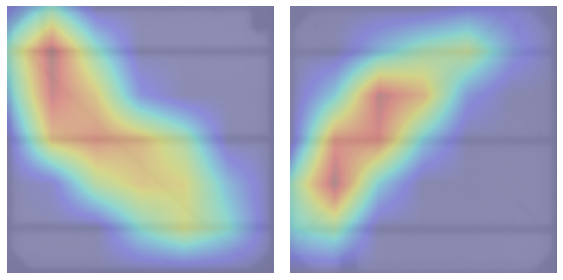

In [18]:
# Render
plot_images(images=images[1:3,...], maps=cam)